# Custom Settings-Set Point

In [1]:
import sys
import time
sys.path.append("..")

from simulation_evaluation.microgrid_simulator import ControllEnvironment
from simulation_evaluation.microgrid_ga_v2 import MicrogridGA
from simulation_evaluation.controller_offline import SpaceShareController
from simulation_evaluation.protection_controller import ProtectionController
day_nr=18
precision=1
battery_power=4.1
battery_max_discharge = 40.0
pv_scale=0.4
priorities=[1, 2, 3, 4, 5, 6, 7]

# Custsom Utility

In [2]:
#Custom Utility Function
def evaluate_individual(individual):
    SoC_max = 100.0
    SoC_min = 40.0
    P_rated = 3000
    wb=we=0.125
    wp=wd=0.25
    for index, row in individual.iterrows():
        util = 0.0
        #Battery Health
        SoC = row['Battery_SoC']
        P_Cons = row['Consumed_Energy']
        Fb_t = (SoC-SoC_min)/(SoC_max-SoC_min)+P_Cons/P_rated
        #Efficiency
        P_System_Load = row['System_Load']
        P_PV_Gen = row['Generated_Energy']
        Fe_t = (P_Cons-P_System_Load)/P_Cons+P_Cons/(P_Cons+P_PV_Gen)
        #Penalty
        Fp_t =  1.0 if row['Battery_SoC']>SoC_min else 0.0
        #Dissatisafaction
        priority_keys = [ x for x in list(individual.keys()) if "_Priority" in x]
        Fd_t = 0.0
        for x in priority_keys:
            Fd_t+=(row[x.split("_Priority")[0]+"_Quota"]*1/row[x])/len(priority_keys)
        #Combine with weights                                  
        individual.loc[index,"Util"] = wb*Fb_t+we*Fe_t+wp*Fp_t+wd*Fd_t
    return sum(individual['Util']) / len(individual)

# Space Shared Controller

In [3]:
#Basic Controller Run
start_time = time.time()
space_shared_controller = SpaceShareController(day_nr=day_nr, precision=precision, battery_power=battery_power, 
                                               battery_max_discharge = battery_max_discharge,
                                               pv_scale=pv_scale,priorities=priorities)

#Utility is only used to calculate final result with this methid
space_shared_controller.evaluate_individual = evaluate_individual
spaceshared_util = space_shared_controller.run()
space_time = (time.time()-start_time)
protection_util = protection_controller.run()
print("Space Shared Util: ",spaceshared_util)
print("Total time: ",space_time)

-------Energy State--------
2.332845833333333
Generated energy: 2230.2661042700174
System Load: 2869.5698831237137
Battery SoC: 96.89867886178861
Remaining Energy: 1693.5420544796366
Priorities:  {1: 'Nursery1_Lights_Quota', 2: 'Nursery1_Sockets_Quota', 3: 'Nursery2_Lights_Quota', 4: 'Nursery2_Sockets_Quota', 5: 'Playground_Lights_Quota', 6: 'Playground_Sockets_Quota', 7: 'Streetlights_Quota'}
------------------------------------------------
For Device: Nursery1_Lights_Quota with energy avialable: 1693.5420544796366
Used Energy:  221.1207786075036
Remaining Energy:  1472.421275872133
Result: 1472.421275872133 Fraction:  1.0
------------------------------------------------
For Device: Nursery1_Sockets_Quota with energy avialable: 1472.421275872133
Used Energy:  0.0
Remaining Energy:  1472.421275872133
Result: 1472.421275872133 Fraction:  1.0
------------------------------------------------
For Device: Nursery2_Lights_Quota with energy avialable: 1472.421275872133
Used Energy:  424.62629

# Safety Controller Run

In [4]:
# Safety Controller Run
start_time = time.time()
protection_controller = ProtectionController(day_nr=day_nr, precision=precision, battery_power=battery_power, 
                                               battery_max_discharge = battery_max_discharge,
                                               pv_scale=pv_scale,priorities=priorities)

#Utility is only used to calculate final result with this methid
protection_controller.evaluate_individual = evaluate_individual

protection_util = protection_controller.run()
print("Protection Util: ",protection_util)
prot_time = (time.time()-start_time)
print("Total time: ",space_time)

-------Energy State--------
Generated energy: 2230.2661042700174
System Load: 2869.5698831237137
Battery SoC: 96.89867886178861
Remaining Energy: 2332.845833333333
Priorities:  {1: 'Nursery1_Lights_Quota', 2: 'Nursery1_Sockets_Quota', 3: 'Nursery2_Lights_Quota', 4: 'Nursery2_Sockets_Quota', 5: 'Playground_Lights_Quota', 6: 'Playground_Sockets_Quota', 7: 'Streetlights_Quota'}
------------------------------------------------
For Hour: 0
Consumed Energy:  255.583333333333  System Load:  146.53479556953587  Generated Energy: 0.0  Device Energy: 109.04853776379713  EnergyDiff:  -255.583333333333  Battery: SoC: 96.89867886178861 Energy_Left: 2.332845833333333
Battery  Energy Available: SoC: 90.66493902439025 Energy_Left: 2.0772625000000002
Resulting Fraction:  1.0
------------------------------------------------
For Hour: 1
Consumed Energy:  249.133333333333  System Load:  134.6843429667551  Generated Energy: 0.0  Device Energy: 114.4489903665779  EnergyDiff:  -249.133333333333  Battery: SoC

# GA Controller

In [5]:
##Extending the GA with prorietary Utility Calculation
#Set Size and Generation Count
my_ga = MicrogridGA(200, 200,day_nr=day_nr, precision=precision, battery_power=battery_power, 
                                               battery_max_discharge = battery_max_discharge, pv_scale=pv_scale,
                    priorities=priorities,step_type="percentage", mutate_chance=0.2, elit_perc=0.05)
#Redefine to new function
my_ga.evaluate_individual = evaluate_individual
my_ga.run()

🧬 GENERATION 0
Started:  2020-07-23 12:32:07.572422
Sizes - Original: 200  Elit: 10  Cross: 50  Mut: 50  CrossMut: 50  Random: 40
Best Individual:  {'Nursery1_Lights_Quota': [0.2, 0.8, 1.0, 0.6, 0.3, 0.5, 0.8, 0.6, 0.6, 0.9, 0.7, 0.8, 0.3, 0.8, 0.2, 0.9, 0.9, 0.8, 0.0, 0.6, 0.7, 0.4, 0.6, 0.2], 'Nursery1_Sockets_Quota': [1.0, 0.7, 1.0, 0.7, 1.0, 0.6, 0.4, 0.1, 0.9, 1.0, 0.9, 0.2, 0.6, 0.6, 0.9, 0.5, 0.9, 0.5, 0.3, 0.9, 0.7, 0.5, 0.2, 0.8], 'Nursery2_Lights_Quota': [0.6, 0.1, 0.4, 0.7, 0.1, 0.8, 0.2, 0.6, 0.3, 0.3, 0.8, 0.9, 0.2, 0.9, 0.5, 0.3, 0.8, 0.5, 0.2, 0.9, 0.1, 0.3, 1.0, 1.0], 'Nursery2_Sockets_Quota': [0.7, 0.8, 0.7, 0.9, 0.6, 1.0, 0.7, 0.2, 0.8, 0.4, 0.5, 0.6, 0.5, 0.9, 0.1, 0.6, 0.9, 0.4, 0.7, 0.5, 0.0, 0.9, 0.7, 0.2], 'Playground_Lights_Quota': [0.2, 0.4, 0.6, 0.4, 0.4, 0.1, 1.0, 0.5, 0.4, 0.1, 0.6, 0.1, 0.4, 0.6, 0.1, 0.8, 0.1, 0.9, 0.7, 0.4, 0.6, 0.8, 0.6, 0.8], 'Playground_Sockets_Quota': [0.7, 0.4, 0.0, 1.0, 0.9, 0.6, 0.5, 0.8, 0.9, 0.9, 0.8, 0.7, 0.4, 0.5, 0.9, 0.1, 0.1

# Comparative Plots

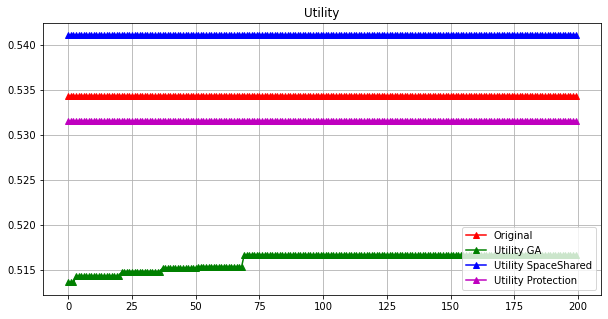

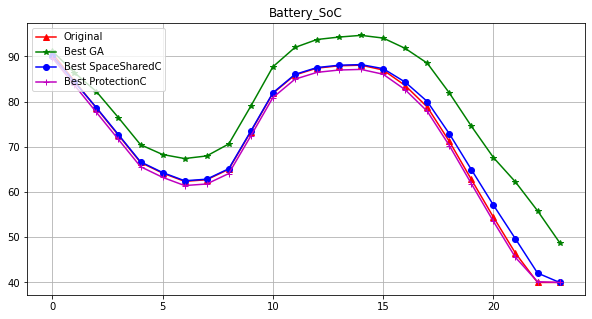

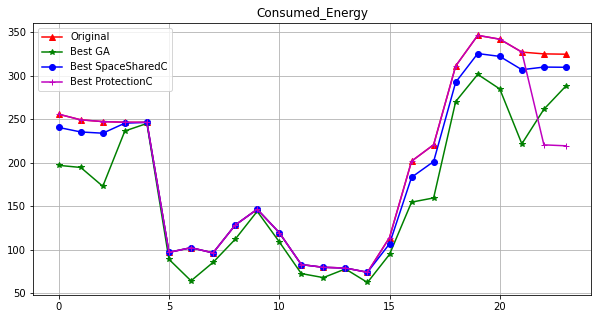

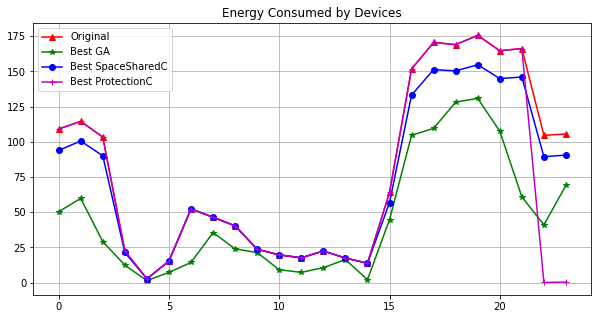

In [6]:
import pandas as pd
import random
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

ga_orig_indi = my_ga.get_original()
util_orig = my_ga.evaluate_individual(ga_orig_indi)
ga_best_indi = my_ga.get_deployed_best()

spaceshare_indi = space_shared_controller.get_deployment()

protection_indi = protection_controller.get_deployment()

f_size = (10,5)
fig,ax = plt.subplots(1,1,figsize=f_size)
plt.title("Utility")
ax.plot([util_orig for x in my_ga.history],'r-^',label="Original")
ax.plot([my_ga.history[x][0] for x in my_ga.history],'g-^',label="Utility GA")
ax.plot([spaceshared_util for x in my_ga.history],'b-^',label="Utility SpaceShared")
ax.plot([protection_util for x in my_ga.history],'m-^',label="Utility Protection")
ax.legend(loc="lower right")
ax.grid()
plt.show()

parameters = ["Battery_SoC","Consumed_Energy"]
for p in parameters:    
    fig,ax = plt.subplots(1,1,figsize=f_size)
    plt.title(p)
    ax.plot(ga_orig_indi.index,ga_orig_indi[p],'r-^', label="Original")
    ax.plot(ga_best_indi.index,ga_best_indi[p],'g-*',label="Best GA")
    ax.plot(spaceshare_indi.index,spaceshare_indi[p],'b-o',label="Best SpaceSharedC")
    ax.plot(protection_indi.index,protection_indi[p],'m-+',label="Best ProtectionC")
    ax.legend(loc="upper left")
    ax.grid()
    plt.show()
#Device Energy
fig,ax = plt.subplots(1,1,figsize=f_size)
plt.title("Energy Consumed by Devices")
ax.plot(ga_orig_indi.index,ga_orig_indi["Consumed_Energy"]-ga_orig_indi["System_Load"],'r-^', label="Original")
ax.plot(ga_best_indi.index,ga_best_indi["Consumed_Energy"]-ga_best_indi["System_Load"],'g-*',label="Best GA")
ax.plot(spaceshare_indi.index,spaceshare_indi["Consumed_Energy"]-spaceshare_indi["System_Load"],'b-o',label="Best SpaceSharedC")
ax.plot(protection_indi.index,protection_indi["Consumed_Energy"]-protection_indi["System_Load"],'m-+',label="Best ProtectionC")
ax.legend(loc="upper left")
ax.grid()
plt.show()